# Baseline-inspired pulses (interactive)

Adjust the controls and click **Play** to rerun the Bloch-sphere animation with a detuning shift and scaled Rabi pulses. The pulse plot below is synchronized: a marker walks along each control as the state evolves.


In [1]:

import json
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import animation, rcParams
import numpy as np
from IPython.display import HTML, display
from qutip import Bloch, Qobj, basis, sesolve, sigmax, sigmay, sigmaz

rcParams["animation.embed_limit"] = 120  # MB embed budget
rcParams["animation.html"] = "jshtml"
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "stix"
rcParams["figure.dpi"] = 115
rcParams["axes.grid"] = False
rcParams["axes.titlesize"] = 13
rcParams["axes.labelsize"] = 12


def find_baseline_dir():
    for root in [Path.cwd(), *Path.cwd().parents]:
        candidate = root / "data" / "baselines" / "_baseline_crab"
        if candidate.exists():
            return candidate
    raise FileNotFoundError("Could not find data/baselines/_baseline_crab from this working directory")


BASELINE_DIR = find_baseline_dir()
metadata = json.loads((BASELINE_DIR / "metadata.json").read_text())
arrays = np.load(BASELINE_DIR / "arrays.npz")

# Static operators and initial state (density converted to ket for sesolve)
SX = sigmax()
SY = sigmay()
SZ = sigmaz()
HX = 0.5 * SX
HZ = 0.5 * SZ

rho0 = Qobj(arrays["rho0"])
_, eigvecs = rho0.eigenstates()
psi0 = eigvecs[-1]
ket1 = basis(2, 1)

T_DEFAULT = 5.0
N_SAMPLES = 200
MAX_FRAMES = 50
RAD_US_TO_MHZ = 1.0 / (2 * np.pi)
MHZ_TO_RAD_US = 2 * np.pi

COLOR_PI = "#1f77b4"
COLOR_RAP = "#d62728"
COLORS = [COLOR_PI, COLOR_RAP]

print(
    f"Baseline loaded from {BASELINE_DIR} (Nt={metadata['summary']['Nt']}, T0={arrays['T'].item()} us)."
)


Baseline loaded from /home/yehon/projects/grape-crab-qoc/data/baselines/_baseline_crab (Nt=201, T0=0.1 us).


In [2]:

# Simulation helpers


def time_grid(T_value):
    return np.linspace(0.0, T_value, N_SAMPLES)


def base_protocols(T_pi, T_rap):
    t_pi = time_grid(T_pi)
    t_rap = time_grid(T_rap)

    pulse_pi = np.sin(np.pi * t_pi / T_pi) ** 2
    omega_ref_pi = np.pi / np.trapezoid(pulse_pi, t_pi)  # area-normalized pi pulse
    pi_omega = omega_ref_pi * pulse_pi
    pi_delta = np.zeros_like(t_pi)

    pulse_rap = np.sin(np.pi * t_rap / T_rap) ** 2
    detuning_rap = np.cos(np.pi * t_rap / T_rap)
    omega_ref_rap = np.pi / np.trapezoid(pulse_rap, t_rap)
    rap_omega = 10.0 * omega_ref_rap * pulse_rap
    rap_delta = 10.0 * detuning_rap

    return [
        {"tag": "pi", "label_tex": r"$\pi$-pulse", "omega": pi_omega, "delta": pi_delta, "t_full": t_pi},
        {"tag": "rap", "label_tex": r"$\text{RAP}$", "omega": rap_omega, "delta": rap_delta, "t_full": t_rap},
    ]


def simulate_protocol(omega_t, delta_t, t):
    H = [
        [HX, lambda tt, args=None: np.interp(tt, t, omega_t)],
        [HZ, lambda tt, args=None: np.interp(tt, t, delta_t)],
    ]
    opts = {"store_states": True, "atol": 1e-8, "rtol": 1e-7}
    result = sesolve(H, psi0, t, e_ops=[SX, SY, SZ], options=opts)
    coords = np.vstack(result.expect)
    psi_T = result.states[-1] if result.states else None
    return coords, psi_T


def fidelity_to_one(psi_T):
    if psi_T is None:
        return float("nan")
    amp = ket1.overlap(psi_T)
    return float(abs(amp) ** 2)


def make_protocols(T_pi, T_rap, omega_scale, detuning_shift_mhz):
    detuning_shift_rad = detuning_shift_mhz * MHZ_TO_RAD_US
    proto_defs = base_protocols(T_pi, T_rap)
    protocols = []
    for base in proto_defs:
        t_full = base["t_full"]
        omega = omega_scale * base["omega"]
        delta = base["delta"] + detuning_shift_rad
        coords_full, psi_T = simulate_protocol(omega, delta, t_full)
        color = COLOR_PI if base["tag"] == "pi" else COLOR_RAP
        tag_tex = r"\pi" if base["tag"] == "pi" else r"\text{RAP}"
        protocols.append(
            {
                "tag": base["tag"],
                "tag_tex": tag_tex,
                "label_tex": base["label_tex"],
                "color": color,
                "t_full": t_full,
                "omega_full": omega,
                "delta_full": delta,
                "omega_mhz": omega * RAD_US_TO_MHZ,
                "delta_mhz": delta * RAD_US_TO_MHZ,
                "coords_full": coords_full,
                "fidelity": fidelity_to_one(psi_T),
                "T": float(t_full[-1]) if len(t_full) else 0.0,
            }
        )
    return protocols


def pulse_limits(protocols):
    max_val = 0.0
    for proto in protocols:
        max_val = max(
            max_val,
            float(np.max(np.abs(proto["omega_mhz"]))),
            float(np.max(np.abs(proto["delta_mhz"]))),
        )
    span = max_val if max_val > 0 else 1.0
    span *= 1.1
    return -span, span


def build_animation(protocols, fps=20):
    if not protocols:
        raise ValueError("No protocols provided")

    t_max = max(proto["T"] for proto in protocols)
    t_min = max(min(proto["T"] for proto in protocols), 1e-3)
    interval_ms = 1.0 / fps
    min_frames_fastest = int(np.ceil(2.0 * fps))  # >=2 seconds for the fastest protocol
    n_frames = min(min_frames_fastest * int(np.ceil(t_max / t_min)), 200)
    global_t = np.linspace(0.0, t_max, n_frames)

    fig = plt.figure(figsize=(12, 7))
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], hspace=0.32, wspace=0.3)
    bloch_axes = [fig.add_subplot(gs[0, i], projection="3d") for i in range(len(protocols))]
    pulse_axes = [fig.add_subplot(gs[1, i]) for i in range(len(protocols))]

    bloch_lines, bloch_points, bloch_vectors = [], [], []
    for ax, proto in zip(bloch_axes, protocols):
        bloch = Bloch(fig=fig, axes=ax)
        bloch.sphere_alpha = 0.14
        bloch.frame_color = "#888888"
        bloch.frame_alpha = 0.2
        bloch.vector_width = 5
        bloch.point_size = [32]
        bloch.point_marker = ["o"]
        bloch.vector_color = [proto["color"]]
        bloch.point_color = [proto["color"]]
        bloch.xlabel = [r"$x$", ""]
        bloch.ylabel = [r"$y$", ""]
        bloch.zlabel = [r"$z$", ""]
        bloch.render()
        ax.set_title(proto["label_tex"])
        ax.set_box_aspect((1, 1, 1))
        trace, = ax.plot([], [], [], color=proto["color"], lw=2.2, alpha=0.9)
        point, = ax.plot([], [], [], marker="o", color=proto["color"], markersize=6)
        vector = ax.quiver(0, 0, 0, 0, 0, 0, color=proto["color"], lw=2.2, arrow_length_ratio=0.25)
        bloch_lines.append(trace)
        bloch_points.append(point)
        bloch_vectors.append(vector)

    omega_lines, delta_lines, omega_markers, delta_markers = [], [], [], []
    ylim_low, ylim_high = pulse_limits(protocols)
    for proto, pax in zip(protocols, pulse_axes):
        omega_line, = pax.plot(proto["t_full"], proto["omega_mhz"], color=proto["color"], label=r"$\Omega(t)$")
        delta_line, = pax.plot(
            proto["t_full"], proto["delta_mhz"], color=proto["color"], linestyle="--", alpha=0.85, label=r"$\Delta(t)$"
        )
        omega_marker, = pax.plot([], [], marker="o", color=proto["color"], markersize=5)
        delta_marker, = pax.plot([], [], marker="x", color=proto["color"], alpha=0.95, markersize=6)
        pax.set_title(rf"{proto['label_tex']}~\text{{pulses}}")
        pax.set_xlabel(r"$t~(\mu s)$")
        pax.set_ylabel(r"$\Omega,\;\Delta~(\text{MHz})$")
        pax.set_xlim(0, float(proto["t_full"][-1]) if len(proto["t_full"]) else 1.0)
        pax.set_ylim(ylim_low, ylim_high)
        pax.legend(loc="upper right", frameon=False)
        omega_lines.append(omega_line)
        delta_lines.append(delta_line)
        omega_markers.append(omega_marker)
        delta_markers.append(delta_marker)

    fidelity_tex = r" \quad ".join([fr"F_{{{proto['tag_tex']}}}=\,{proto['fidelity']:.4f}" for proto in protocols])
    fig.text(0.5, 0.02, fr"$ {fidelity_tex} $", ha="center", fontsize=13, color="#222222")
    fig.suptitle(r"$\text{Bloch trajectories and control fields}$", y=0.97, fontsize=15)
    fig.subplots_adjust(top=0.9, bottom=0.1)

    def update(frame):
        t_global = global_t[frame % len(global_t)]
        artists = []
        for i, proto in enumerate(protocols):
            t_full = proto["t_full"]
            coords_full = proto["coords_full"]
            t_now = min(t_global, proto["T"])

            x = np.interp(t_now, t_full, coords_full[0])
            y = np.interp(t_now, t_full, coords_full[1])
            z = np.interp(t_now, t_full, coords_full[2])

            path_mask = t_full <= t_now
            bloch_lines[i].set_data(coords_full[0, path_mask], coords_full[1, path_mask])
            bloch_lines[i].set_3d_properties(coords_full[2, path_mask])
            bloch_points[i].set_data([x], [y])
            bloch_points[i].set_3d_properties([z])

            bloch_vectors[i].remove()
            bloch_vectors[i] = bloch_axes[i].quiver(
                0,
                0,
                0,
                x,
                y,
                z,
                color=proto["color"],
                lw=2.2,
                arrow_length_ratio=0.25,
                normalize=False,
            )
            artists.extend([bloch_lines[i], bloch_points[i], bloch_vectors[i]])

            omega_markers[i].set_data([t_now], [np.interp(t_now, t_full, proto["omega_mhz"])])
            delta_markers[i].set_data([t_now], [np.interp(t_now, t_full, proto["delta_mhz"])])
            artists.extend([omega_markers[i], delta_markers[i]])
        return artists

    anim = animation.FuncAnimation(fig, update, frames=len(global_t), interval=interval_ms, blit=False)
    return fig, anim, len(global_t), interval_ms, fps, fidelity_tex


PermissionError: [Errno 13] Permission denied: 'ffmpeg'

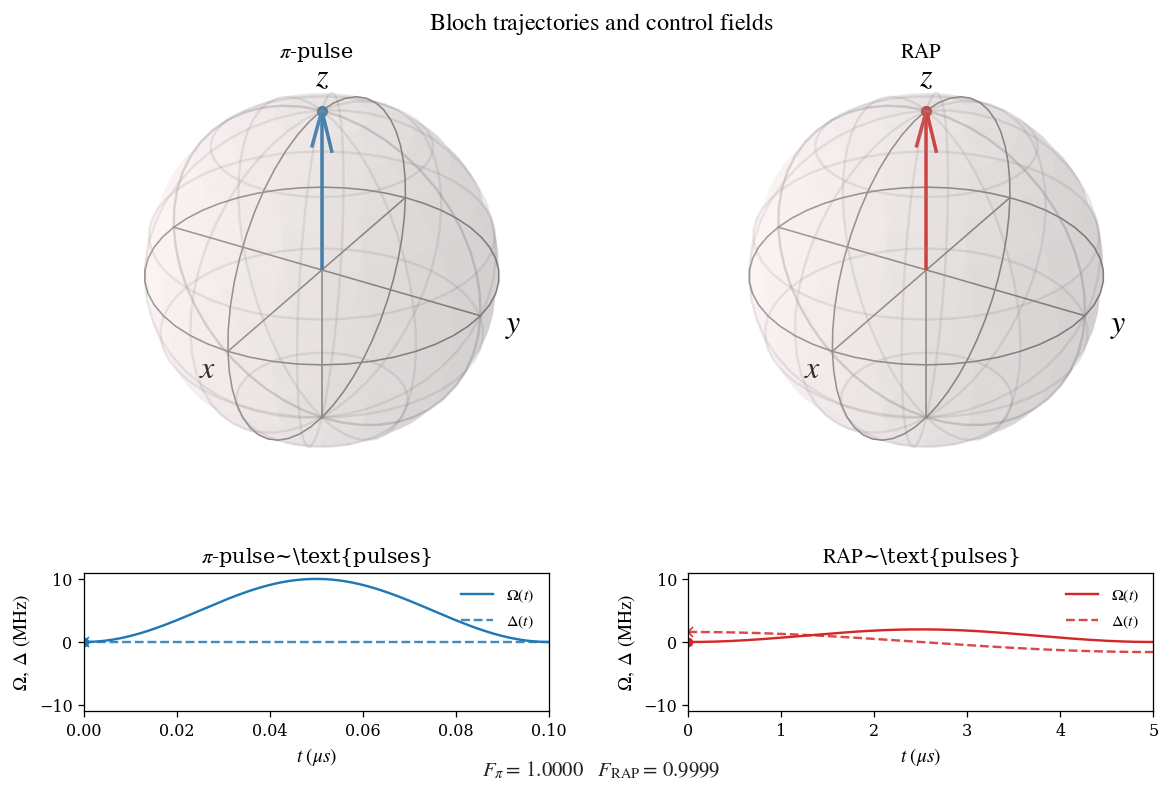

In [ ]:

# Interactive controls: sliders update parameters silently; Play or Save triggers work.

control_width = "230px"
omega_scale = widgets.FloatSlider(
    value=1.0,
    min=0.25,
    max=2.5,
    step=0.05,
    description="",
    readout_format=".2f",
    continuous_update=False,
    layout=widgets.Layout(width=control_width),
)
detuning_shift = widgets.FloatSlider(
    value=0.0,
    min=-5.0,
    max=5.0,
    step=0.05,
    description="",
    readout_format=".2f",
    continuous_update=False,
    layout=widgets.Layout(width=control_width),
)
T_pi_slider = widgets.FloatSlider(
    value=T_DEFAULT,
    min=0.1,
    max=10.0,
    step=0.1,
    description="",
    readout_format=".2f",
    continuous_update=False,
    layout=widgets.Layout(width=control_width),
)
T_rap_slider = widgets.FloatSlider(
    value=T_DEFAULT,
    min=0.1,
    max=10.0,
    step=0.1,
    description="",
    readout_format=".2f",
    continuous_update=False,
    layout=widgets.Layout(width=control_width),
)

play_button = widgets.Button(description="Play", icon="play", button_style="success")
save_button = widgets.Button(description="Save MP4", icon="save", button_style="info")
status = widgets.HTML()
fidelity_display = widgets.HTMLMath(value="")
save_status = widgets.HTML()

labels = {
    "omega": widgets.HTMLMath(value=r"$\Omega$ scale"),
    "delta": widgets.HTMLMath(value=r"$\Delta\_\text{shift}~(\text{MHz})$"),
    "Tpi": widgets.HTMLMath(value=r"$T\_\pi~(\mu s)$"),
    "Trap": widgets.HTMLMath(value=r"$T\_{\text{RAP}}~(\mu s)$"),
}

controls_row = widgets.HBox(
    [
        widgets.VBox([labels["omega"], omega_scale]),
        widgets.VBox([labels["delta"], detuning_shift]),
        widgets.VBox([labels["Tpi"], T_pi_slider]),
        widgets.VBox([labels["Trap"], T_rap_slider]),
        widgets.VBox([widgets.HTML("&nbsp;"), play_button]),
        widgets.VBox([widgets.HTML("&nbsp;"), save_button]),
    ],
    layout=widgets.Layout(flex_flow="row wrap", align_items="center", grid_gap="10px"),
)

out = widgets.Output()
last_params = {}


def update_status(*_):
    status.value = rf"$\text{{Parameters: }}\Omega_{{\text{{scale}}}}={omega_scale.value:.2f},\;"             rf"\Delta_{{\text{{shift}}}}={detuning_shift.value:.2f}\;\text{{MHz}},\;"             rf"T_\pi={T_pi_slider.value:.2f}\;\mu\text{{s}},\;"             rf"T_{{\text{{RAP}}}}={T_rap_slider.value:.2f}\;\mu\text{{s}}.$"


for slider in (omega_scale, detuning_shift, T_pi_slider, T_rap_slider):
    slider.observe(update_status, names="value")
update_status()


def render_animation_and_display(save_path=None):
    protocols = make_protocols(T_pi_slider.value, T_rap_slider.value, omega_scale.value, detuning_shift.value)
    fig, anim, n_frames, interval_ms, fps, fidelity_tex = build_animation(protocols)
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        writer = animation.FFMpegWriter(fps=fps, bitrate=3200)
        anim.save(str(save_path), writer=writer, dpi=180)
        plt.close(fig)
        return n_frames, fps, fidelity_tex
    html = anim.to_jshtml()
    plt.close(fig)
    display(HTML(html))
    return n_frames, fps, fidelity_tex


def on_play(_):
    with out:
        out.clear_output(wait=True)
        status.value = rf"$\text{{Running}}\;\left(\Omega_{{\text{{scale}}}}={omega_scale.value:.2f},\;"                 rf"\Delta_{{\text{{shift}}}}={detuning_shift.value:.2f}\;\text{{MHz}},\;"                 rf"T_\pi={T_pi_slider.value:.2f}\;\mu\text{{s}},\;"                 rf"T_{{\text{{RAP}}}}={T_rap_slider.value:.2f}\;\mu\text{{s}}\right).$"
        try:
            n_frames, fps, fidelity_tex = render_animation_and_display()
            last_params.clear()
            last_params.update(
                {
                    "T_pi": T_pi_slider.value,
                    "T_rap": T_rap_slider.value,
                    "omega_scale": omega_scale.value,
                    "detuning_shift": detuning_shift.value,
                    "fidelity_tex": fidelity_tex,
                    "fps": fps,
                    "n_frames": n_frames,
                }
            )
            fidelity_display.value = f"$$ {fidelity_tex} $$"
            status.value = rf"$\text{{Complete: }}{n_frames}\;\text{{frames at}}\;{fps}\;\text{{fps.}}$"
        except Exception as exc:  # noqa: BLE001
            status.value = f"<span style='color:#cc0000;'>Simulation failed: {exc}</span>"
            raise


def on_save(_):
    if not last_params:
        save_status.value = "<span style='color:#cc0000;'>Run Play once before saving.</span>"
        return
    save_status.value = "Saving MP4..."
    try:
        target_dir = Path("artifacts/animations")
        fname = target_dir / (
            f"bloch_Tpi{T_pi_slider.value:.2f}_Trap{T_rap_slider.value:.2f}_"
            f"O{omega_scale.value:.2f}_D{detuning_shift.value:.2f}.mp4"
        )
        n_frames, fps, fidelity_tex = render_animation_and_display(save_path=fname)
        fidelity_display.value = f"$$ {fidelity_tex} $$"
        save_status.value = rf"Saved MP4 to {fname} ({n_frames} frames @ {fps} fps)."
    except Exception as exc:  # noqa: BLE001
        save_status.value = f"<span style='color:#cc0000;'>Save failed: {exc}</span>"
        raise


play_button.on_click(on_play)
save_button.on_click(on_save)

layout = widgets.VBox(
    [
        widgets.HTMLMath("<b>Adjust sliders, then press Play.</b>"),
        controls_row,
        status,
        fidelity_display,
        save_status,
        out,
    ]
)

display(layout)
